In [ ]:
import pandas as pd
import numpy as np
import random
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
import tensorflow as tf 
tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

Read the dataset

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Thesis_Code/News_Category_Dataset_v2.json', lines=True)
print('Shape: ' + str(df.shape))
display(df.head(5))

Shape: (200853, 6)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Select all 41  topics and headline column

In [ ]:
df['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [ ]:
column_selected = 'headline' 
#classes = df['category'].unique().tolist()
classes=['ENTERTAINMENT', 'POLITICS', 'SPORTS', 'TRAVEL', 'WELLNESS']

df = df[[column_selected, 'category']]
df = df[df['category'].isin(classes)]
print('New shape: ' + str(df.shape))
display(df.head(9000))

New shape: (81395, 2)


,headline,category
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT
5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT
...,...,...
16212,Criminalizing Immigrants Puts Them At Risk Dur...,POLITICS
16214,"Hillary Lost The Election, But Kate McKinnon W...",ENTERTAINMENT
16218,Trump Still Hasn't Officially Declared The Opi...,POLITICS
16219,6 Dreamers Sue Trump Administration Over DACA ...,POLITICS


### Labels

Distribution of labels

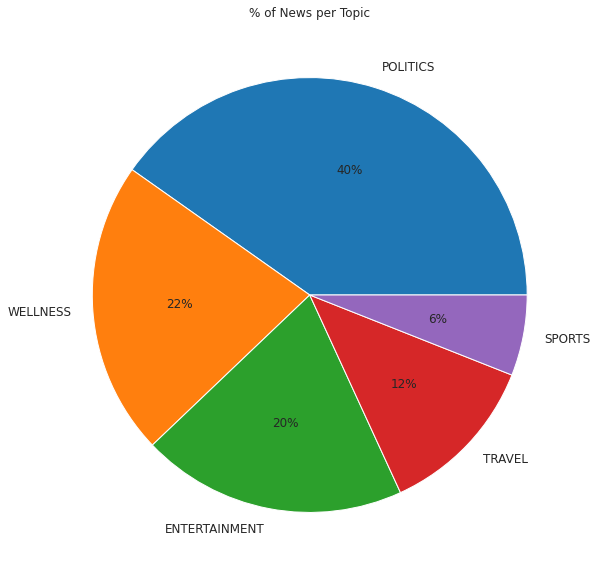

In [ ]:
plot = df.category.value_counts(normalize=True).plot.pie(autopct='%1.0f%%',
                                                         title='% of News per Topic', 
                                                         figsize=(10, 10), 
                                                         fontsize=12,
                                                          
                                                         ylabel='')



```
# This is formatted as code
```

Encode labels (ENTERTAINMENT -> 0, POLITICS -> 1, SPORTS -> 2, TRAVEL -> 3, WELLNESS -> 4......)

In [ ]:
le = LabelEncoder()
df['category'] = le.fit_transform(df.category)
classes = list(le.classes_)
print(classes)

['ENTERTAINMENT', 'POLITICS', 'SPORTS', 'TRAVEL', 'WELLNESS']


### Word Count

Descriptive table of the number of words

In [ ]:
word_lens = df[column_selected].str.split(" ").str.len()
display(word_lens.describe().round(2))

count    81395.00
mean         9.59
std          3.12
min          1.00
25%          7.00
50%         10.00
75%         12.00
max         44.00
Name: headline, dtype: float64

Histogram

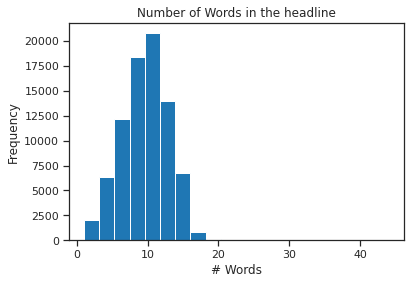

In [ ]:
ax = word_lens.plot.hist(bins=20, title='Number of Words in the ' + column_selected)
plot = ax.set_xlabel("# Words")

# Preprocessing
- Lower-case text.
- Replacing contractions.
- Cleaning up special characters.
- Removing extra whitespaces.
- Removing stopwords.
- Lemmatize.

In [ ]:
class Normalizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        # Replace contractions
        text = re.sub(r"\'s", " is ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)

    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        
        tokens = self.tokenize(text)
        tokens = self.remove_stop_words(tokens)
        tokens = self.lemmatize(tokens)
        text = self.return_sentences(tokens)
        return text

Create a copy of the dataset to retain original headlines

In [ ]:
df_final = df.copy()

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Apply the normalizer to all the headlines

In [ ]:
norm = Normalizer()
df_final[column_selected] = df_final[column_selected].progress_apply(lambda x: norm.clean_all(x))

  0%|          | 0/81395 [00:00<?, ?it/s]

Example

In [ ]:
data_no = 14
print('Original: ' + df[column_selected].iloc[data_no])
print('New: ' + df_final[column_selected].iloc[data_no])

Original: Ireland Votes To Repeal Abortion Amendment In Landslide Referendum
New: ireland vote repeal abortion amendment landslide referendum


In [ ]:
display(df_final.tail(10))

,headline,category
200800,sleep library 11 soothing book bedtime,4
200802,benefit caring pet,4
200804,tea time beneath western ghat photo,3
200805,beginning surprising advice centenarian,4
200838,sundance ice shade american race cinema,0
200839,girl dragon tattoo india release canceled loca...,0
200849,maria sharapova stunned victoria azarenka aust...,2
200850,giant patriot jet colt among improbable super ...,2
200851,aldon smith arrested 49ers linebacker busted duo,2
200852,dwight howard rip teammate magic loss hornet,2


In [ ]:
df_final['category'].unique().tolist()

[0, 1, 2, 3, 4]

In [ ]:
df_final.shape

(81395, 2)

## Split Train and Test
Train (80%) and Test (20%). Stratified to maintain the proportion of the labels

In [ ]:
X = df_final[column_selected]
y = df_final.category
print(y)


1         0
2         0
3         0
4         0
5         0
         ..
200839    0
200849    2
200850    2
200851    2
200852    2
Name: category, Length: 81395, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
print('Shape train: ' + str(X_train.shape))
print('Shape test: ' + str(X_test.shape))

Shape train: (65116,)
Shape test: (16279,)


# Encoding

## Text encoding - TF-IDF

Apply Tf-Idf strategy to encode the text

Ignore words that appear in less than 10 documents and more than 80% of the documents

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# tfidf = TfidfVectorizer(max_df=0.8, min_df=10, use_idf=True, smooth_idf=True, sublinear_tf=True)
# X_train_enc = tfidf.fit_transform(X_train)
# X_test_enc = tfidf.fit_transform(X_test)

# data_no = 5
# print('Size of the Vocabulary for train data: ' + str(X_train_enc.shape[1]))
# print('Size of the Vocabulary for test data: ' + str(X_test_enc.shape[1]))
# print('Original: ' + X_train.iloc[data_no])
# print('Encoded: ' + str(X_train_enc[data_no]))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

tfidf = TfidfVectorizer(max_df=0.8, min_df=10, use_idf=True, smooth_idf=True, sublinear_tf=True)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)


data_no = 5
print('Size of the Vocabulary for train data: ' + str(X_train_enc.shape[1]))
print('Size of the Vocabulary for test data: ' + str(X_test_enc.shape[1]))
print('Original: ' + X_train.iloc[data_no])
print('Encoded: ' + str(X_train_enc[data_no]))

Size of the Vocabulary for train data: 5910
Size of the Vocabulary for test data: 5910
Original: 50 000 trip hawaii look like
Encoded:   (0, 3125)	0.3359623491772339
  (0, 3177)	0.3610695502257701
  (0, 2436)	0.4660172973617114
  (0, 5496)	0.39746934718535953
  (0, 0)	0.4282536202374546
  (0, 62)	0.44519985758793656


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(X_train) 

# X_train_enc = vectorizer.transform(X_train)
# X_test_enc = vectorizer.transform(X_test)

# data_no = 5
# print('Size of the Vocabulary for train data: ' + str(X_train_enc.shape[1]))
# print('Size of the Vocabulary for test data: ' + str(X_test_enc.shape[1]))
# print('Original: ' + X_train.iloc[data_no])
# print('Encoded: ' + str(X_train_enc[data_no]))

In [ ]:
print(X_test_enc[0])

  (0, 5838)	0.30708230255674207
  (0, 4132)	0.42230270407454656
  (0, 3775)	0.5692519750175791
  (0, 3368)	0.4317214265307296
  (0, 1951)	0.35498012739376206
  (0, 267)	0.3015274341683382


## Users encoding

Use Users class to generate and encode the users as a dictionary

In [ ]:
class Users:
    # Receives a number of users and classes (interests)
    def __init__(self, n_users, classes):
        if n_users == 0:
            self.users = {}
        else:
            self.users = self.create_users(n_users, classes)
        
    def create_users(self, n_users, classes):
        users = [('user_' + str(i), random.sample(classes, 
                                                  random.randint(1,5))) for i in range(1, n_users + 1)]
        return dict(users)
        
    def add_user(self, user_name, topics_list):
        self.users[user_name] = topics_list
    
    def delete_user(self, user_name):
        del self.users[user_name]
    
    def get_preferences(self, user_name):
        return self.users[user_name]
    
    def get_users_names(self):
        return list(self.users.keys())
    
    def get_items(self):
        return self.users.items()

Generate random users

In [ ]:
users = Users(50, classes)
display(users.users)

{'user_1': ['TRAVEL', 'WELLNESS', 'ENTERTAINMENT'],
 'user_10': ['SPORTS', 'POLITICS', 'TRAVEL', 'ENTERTAINMENT', 'WELLNESS'],
 'user_11': ['ENTERTAINMENT', 'TRAVEL', 'SPORTS'],
 'user_12': ['TRAVEL', 'POLITICS', 'ENTERTAINMENT'],
 'user_13': ['TRAVEL', 'POLITICS', 'ENTERTAINMENT', 'SPORTS', 'WELLNESS'],
 'user_14': ['POLITICS', 'TRAVEL'],
 'user_15': ['ENTERTAINMENT', 'POLITICS', 'SPORTS', 'TRAVEL', 'WELLNESS'],
 'user_16': ['TRAVEL', 'ENTERTAINMENT', 'WELLNESS', 'SPORTS'],
 'user_17': ['ENTERTAINMENT', 'POLITICS'],
 'user_18': ['ENTERTAINMENT', 'POLITICS', 'SPORTS'],
 'user_19': ['WELLNESS'],
 'user_2': ['TRAVEL', 'POLITICS', 'ENTERTAINMENT', 'SPORTS', 'WELLNESS'],
 'user_20': ['POLITICS'],
 'user_21': ['WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS', 'POLITICS'],
 'user_22': ['SPORTS', 'ENTERTAINMENT', 'TRAVEL', 'POLITICS'],
 'user_23': ['POLITICS'],
 'user_24': ['ENTERTAINMENT', 'WELLNESS', 'TRAVEL', 'SPORTS'],
 'user_25': ['WELLNESS', 'POLITICS', 'TRAVEL', 'SPORTS'],
 'user_26': [

# Modelling

Train 3 different models

## Neural Network

In [ ]:
# !pip install tensorflow==2.6.4

In [ ]:
from tensorflow.keras.utils import to_categorical


y_train_one_hot_encoder = to_categorical(y_train)
y_test_one_hot_encoder = to_categorical(y_test)

In [ ]:
X_train_enc = X_train_enc.sorted_indices()
X_test_enc = X_test_enc.sorted_indices()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
def get_model():
    
    # Neural network
    model = Sequential()
    model.add(Dense(256, input_shape=(X_train_enc.shape[1],), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
model = get_model()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               1513216   
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 200)               51400     
                                                                 
 dropout_21 (Dropout)        (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 160)               32160     
                                                                 
 dropout_22 (Dropout)        (None, 160)               0         
                                                                 
 dense_27 (Dense)            (None, 120)              

#### Plotting model architecture

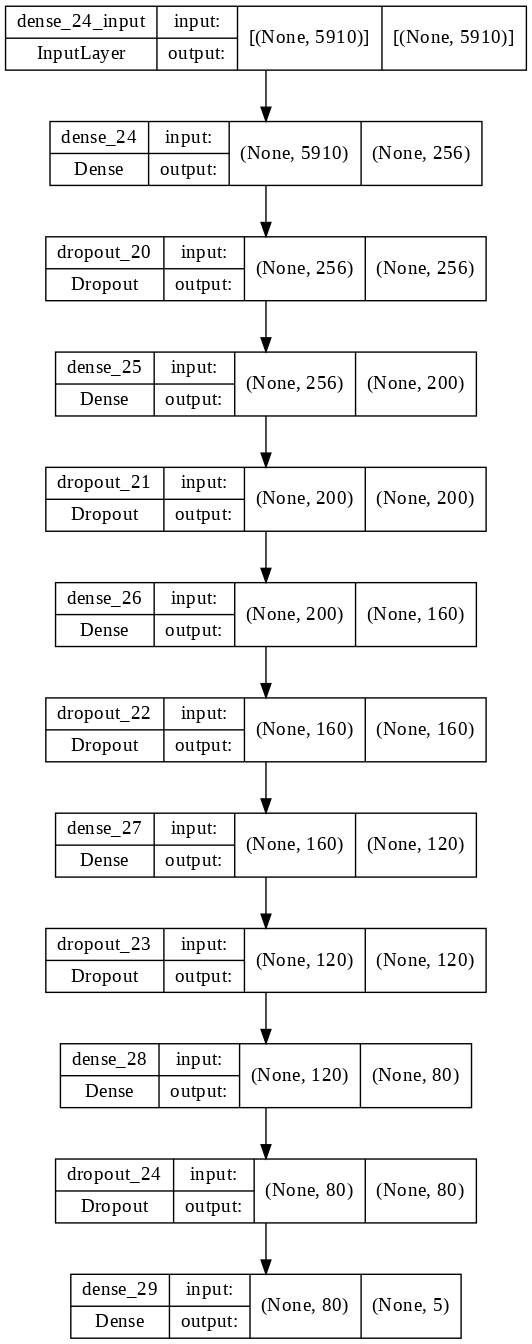

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/Thesis_Code/nn_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
print("Compile model ...")
history = model.fit(X_train_enc, y_train_one_hot_encoder, validation_data=(X_test_enc, y_test_one_hot_encoder) ,epochs=70, batch_size=32)

Compile model ...
Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_24/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_24/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_24/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


2035/2035 [==============================] - 24s 8ms/step - loss: 0.6388 - accuracy: 0.7795 - val_loss: 0.4103 - val_accuracy: 0.8708
Epoch 2/70
2035/2035 [==============================] - 11s 5ms/step - loss: 0.3515 - accuracy: 0.8941 - val_loss: 0.4047 - val_accuracy: 0.8714
Epoch 3/70
2035/2035 [==============================] - 11s 5ms/step - loss: 0.2482 - accuracy: 0.9249 - val_loss: 0.4216 - val_accuracy: 0.8722
Epoch 4/70
2035/2035 [==============================] - 12s 6ms/step - loss: 0.1723 - accuracy: 0.9499 - val_loss: 0.4823 - val_accuracy: 0.8717
Epoch 5/70
2035/2035 [==============================] - 11s 6ms/step - loss: 0.1147 - accuracy: 0.9653 - val_loss: 0.5763 - val_accuracy: 0.8731
Epoch 6/70
2035/2035 [==============================] - 12s 6ms/step - loss: 0.0886 - accuracy: 0.9732 - val_loss: 0.7344 - val_accuracy: 0.8705
Epoch 7/70
2035/2035 [==============================] - 12s 6ms/step - loss: 0.0684 - accuracy: 0.9793 - val_loss: 0.7318 - val_accuracy: 0.8

In [ ]:
#saving model in json format
model_path = '/content/drive/MyDrive/Thesis_Code/'
model_json = model.to_json()
with open(model_path+"nn_model.json", "w") as json_file:
    json_file.write(model_json)
  
model.save_weights(model_path+"nn_model.h5")

No.of epochs: 70


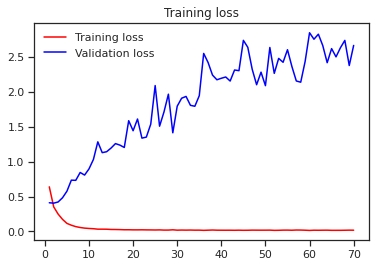

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
print('No.of epochs: '+ str(len(loss)))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')

plt.title('Training loss')
plt.legend(loc=0)
plt.figure()

plt.show()

No.of epochs: 70


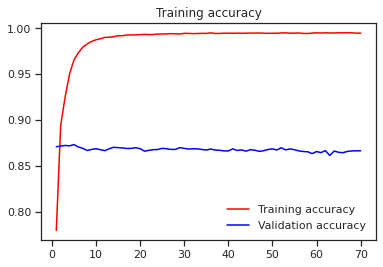

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracy= history.history['accuracy']
validation_accuracy= history.history['val_accuracy']

epochs = range(1,len(accuracy)+1)
print('No.of epochs: '+ str(len(accuracy)))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')

plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

## LinearSVC

Train LinearSVC using gridsearch, stratified cross-validation and optimizing the balanced accuracy

In [ ]:
param_grid = { 
    'penalty': ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'C': np.arange(0.1, 1.1, 0.1),
    'class_weight': ['balanced']
}

svc = LinearSVC(random_state=9)
svc_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10, # Stratified Kfold by default (cv)
                       scoring='balanced_accuracy', refit=True,
                       return_train_score=False, n_jobs=-1, verbose=1)
svc_clf.fit(X_train_enc, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/usr/l

GridSearchCV(cv=10, estimator=LinearSVC(random_state=9), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
# save the model to drive
filename_LinearSVC = '/content/drive/MyDrive/Thesis_Code/model_LinearSVC.sav'
pickle.dump(svc_clf, open(filename_LinearSVC, 'wb'))

In [ ]:
display(pd.DataFrame(svc_clf.cv_results_).sort_values('rank_test_score').shape)
print('Best score: ' + str(svc_clf.best_score_))
print('Best params: ' + str(svc_clf.best_params_))

(40, 22)

Best score: 0.8576955186312049
Best params: {'C': 0.2, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


## Naive Bayes

In [ ]:
param_grid = { 
    'alpha': np.arange(0, 1.1, 0.1),
    'fit_prior': [True, False],
}

svc = MultinomialNB()
nb_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10, # Stratified Kfold by default (cv)
                      scoring='balanced_accuracy', refit=True,
                      return_train_score=False, n_jobs=-1, verbose=1)
nb_clf.fit(X_train_enc, y_train)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'fit_prior': [True, False]},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
# save the model to drive
filename_MultinomialNB = '/content/drive/MyDrive/Thesis_Code/model_MultinomialNB.sav'
pickle.dump(nb_clf, open(filename_MultinomialNB, 'wb'))

In [ ]:
display(pd.DataFrame(nb_clf.cv_results_).sort_values('rank_test_score').head(10))
print('Best score: ' + str(nb_clf.best_score_))
print('Best params: ' + str(nb_clf.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
11,0.029922,0.004878,0.003808,0.001823,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.851701,0.845438,0.847919,0.840930,0.851547,0.843503,0.846515,0.850543,0.844000,0.844888,0.846698,0.003471,1
13,0.028301,0.004477,0.003208,0.000118,0.6,False,"{'alpha': 0.6000000000000001, 'fit_prior': False}",0.851655,0.847043,0.847174,0.840838,0.850877,0.842327,0.845016,0.850683,0.844878,0.844024,0.846451,0.003527,2
9,0.027933,0.004340,0.003264,0.000225,0.4,False,"{'alpha': 0.4, 'fit_prior': False}",0.851024,0.847127,0.847934,0.840031,0.851610,0.842562,0.846622,0.850015,0.843657,0.843871,0.846445,0.003657,3
15,0.027949,0.001829,0.003228,0.000222,0.7,False,"{'alpha': 0.7000000000000001, 'fit_prior': False}",0.852124,0.845821,0.846634,0.841294,0.849779,0.841772,0.844106,0.851180,0.845075,0.842663,0.846045,0.003669,4
7,0.028899,0.005844,0.003295,0.000230,0.3,False,"{'alpha': 0.30000000000000004, 'fit_prior': Fa...",0.849975,0.848127,0.846268,0.839002,0.852262,0.840239,0.844188,0.849869,0.844993,0.844248,0.845917,0.004050,5
17,0.030551,0.006029,0.003339,0.000152,0.8,False,"{'alpha': 0.8, 'fit_prior': False}",0.852616,0.845341,0.846461,0.841114,0.848331,0.841920,0.843205,0.851760,0.844116,0.844008,0.845887,0.003725,6
21,0.027446,0.002122,0.003247,0.000338,1.0,False,"{'alpha': 1.0, 'fit_prior': False}",0.852561,0.842873,0.845086,0.839801,0.849564,0.840019,0.842817,0.853363,0.844406,0.844697,0.845519,0.004548,7
19,0.028420,0.002755,0.003254,0.000169,0.9,False,"{'alpha': 0.9, 'fit_prior': False}",0.852603,0.844112,0.844999,0.840408,0.848697,0.841338,0.843760,0.852510,0.842085,0.844183,0.845470,0.004143,8
5,0.029180,0.004972,0.003233,0.000223,0.2,False,"{'alpha': 0.2, 'fit_prior': False}",0.849563,0.847623,0.845101,0.838192,0.850962,0.837278,0.843131,0.847298,0.844143,0.845834,0.844912,0.004235,9
3,0.028300,0.003715,0.003272,0.000219,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.841562,0.844340,0.840867,0.834514,0.845608,0.835505,0.839873,0.842717,0.840653,0.842522,0.840816,0.003336,10


Best score: 0.8466984106306438
Best params: {'alpha': 0.5, 'fit_prior': False}


# Load The Models

### Linear SVC

In [ ]:
filename_LinearSVC = '/content/drive/MyDrive/Thesis_Code/model_LinearSVC.sav'
svc_clf = pickle.load(open(filename_LinearSVC, 'rb'))

### Multinomial Naive Bayes

In [ ]:
filename_MultinomialNB = '/content/drive/MyDrive/Thesis_Code/model_MultinomialNB.sav'
nb_clf = pickle.load(open(filename_MultinomialNB, 'rb'))

### Neural Network

In [ ]:
#Loading model in json format
from keras.models import model_from_json
model_path = '/content/drive/MyDrive/Thesis_Code/'


json_file = open(model_path+'nn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights(model_path+'nn_model.h5')

model.compile(loss='categorical_crossentropy',
         optimizer='Adam',
         metrics=[tf.keras.metrics.BinaryAccuracy()])

# Results

Create the functions to obtain the metrics:
- Accuracy, Balanced accuracy and Report
- Confusion matrix
- Roc curve

In [ ]:
def general_metrics(y_test, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred).round(2)))
    print('Balanced Accuracy: ' + str(balanced_accuracy_score(y_test, y_pred).round(2)))
    print('Report:')
    print(classification_report(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred, classes):
    fig, ax = plt.subplots(figsize=(10, 8))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=classes)
    cmp.plot(ax=ax)
    plt.xticks(rotation=90);
    plt.show()
    
from random import randint
def plot_roc_curve(y_test, y_score, classes):
    n_classes = len(classes)
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
             color="tab:pink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
             label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
             color="tab:gray", linestyle=":", linewidth=4,)


    colors = []
    no_of_colors = len(classes)

    for i in range(no_of_colors):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    for i, color in enumerate(colors):
        
        type_class = classes[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                 label="ROC curve of " + type_class +" (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()

## Ensemble Results

In [ ]:
def hybrid_prediction( test_data,   svc_model, nn_model, nb_model,  classes):
    #print('True label: ' + classes[new[1]])
    
    new_enc = test_data
    new_enc_sorted = X_test_enc.sorted_indices()

    svc_idx_class = svc_model.predict(new_enc)
    nb_idx_class = nb_model.predict(new_enc)
    nn_idx_class = nn_model.predict(new_enc_sorted).argmax(axis=1)
    prediction_df = pd.DataFrame({'svc_idx_class': svc_idx_class.tolist(), 'nb_idx_class': nb_idx_class.tolist(), 'nn_idx_class':nn_idx_class.tolist()})
    prediction_df['hybrid_pred'] = 0
    for i in range(0,len(prediction_df)):
      prediction_df['hybrid_pred'].iloc[i] = prediction_df.iloc[i].value_counts().index[0]
    y_pred = prediction_df['hybrid_pred']
    return y_pred

In [ ]:
y_pred = hybrid_prediction( X_test_enc,  svc_clf, model, nb_clf,  classes)
general_metrics(y_test, y_pred)

Accuracy: 0.88
Balanced Accuracy: 0.86
Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3212
           1       0.94      0.91      0.92      6548
           2       0.75      0.79      0.77       977
           3       0.84      0.85      0.84      1977
           4       0.86      0.87      0.86      3565

    accuracy                           0.88     16279
   macro avg       0.85      0.86      0.85     16279
weighted avg       0.88      0.88      0.88     16279



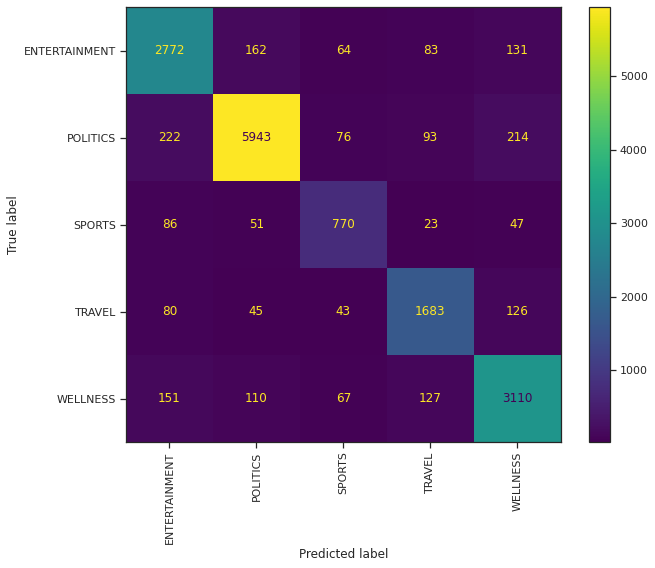

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes)

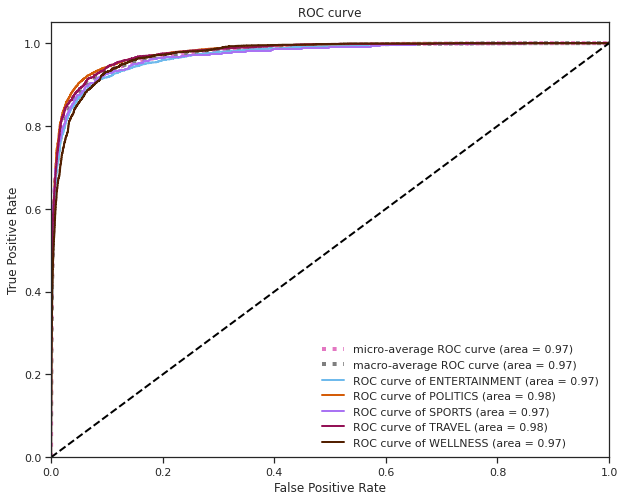

In [ ]:
plot_roc_curve(y_test, y_score, classes)

## LinearSVC Results

In [ ]:
y_pred = svc_clf.predict(X_test_enc)
y_score = svc_clf.decision_function(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.88
Balanced Accuracy: 0.86
Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3212
           1       0.94      0.91      0.92      6548
           2       0.76      0.79      0.77       977
           3       0.84      0.85      0.84      1977
           4       0.84      0.88      0.86      3565

    accuracy                           0.88     16279
   macro avg       0.85      0.86      0.85     16279
weighted avg       0.88      0.88      0.88     16279



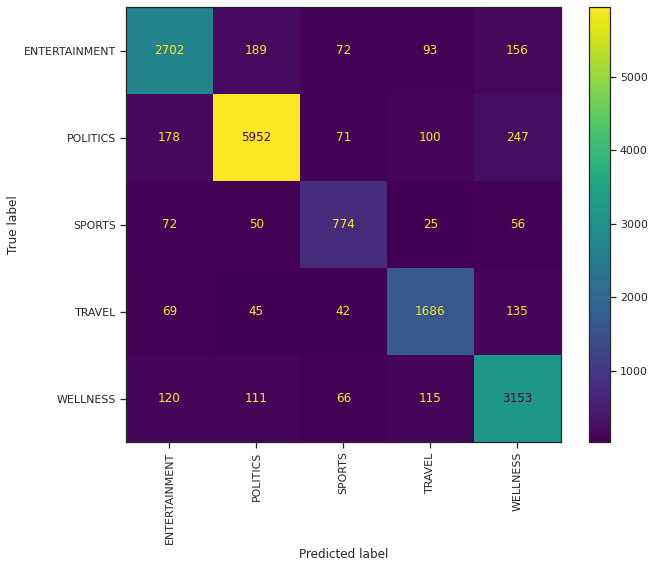

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes)

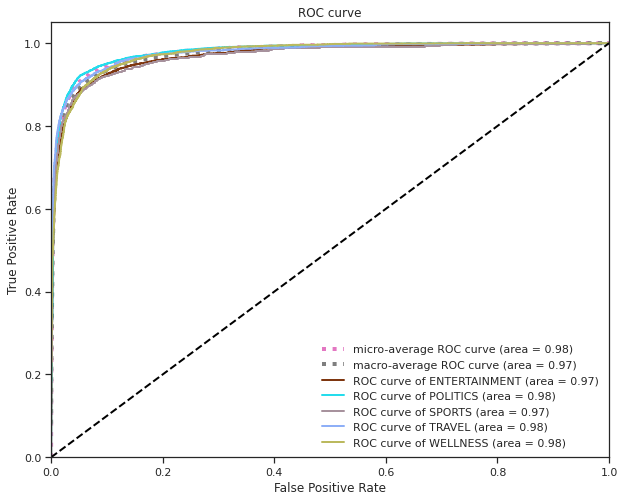

In [ ]:
plot_roc_curve(y_test, y_score, classes)

## Naive Bayes Results

In [ ]:
y_pred = nb_clf.predict(X_test_enc)
y_score = nb_clf.predict_proba(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.85
Balanced Accuracy: 0.85
Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3212
           1       0.94      0.87      0.91      6548
           2       0.62      0.83      0.71       977
           3       0.77      0.86      0.82      1977
           4       0.87      0.82      0.85      3565

    accuracy                           0.85     16279
   macro avg       0.81      0.85      0.82     16279
weighted avg       0.86      0.85      0.86     16279



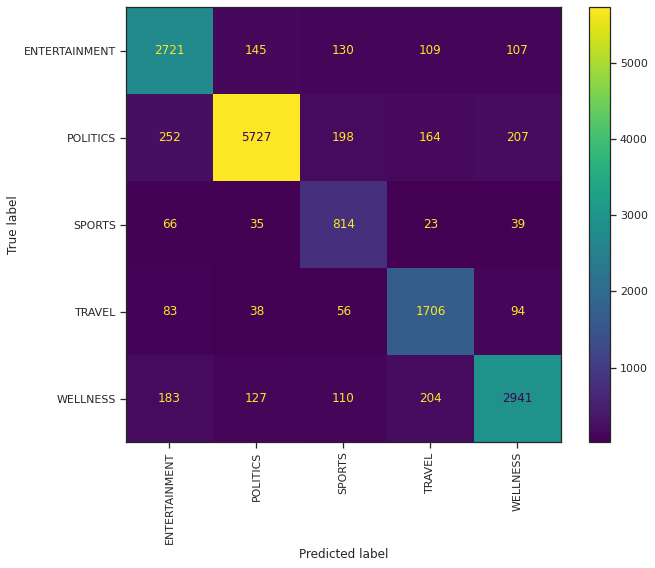

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes)

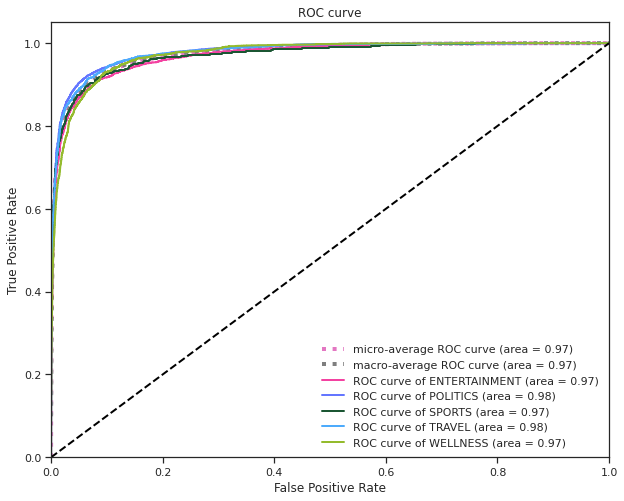

In [ ]:
plot_roc_curve(y_test, y_score, classes)

## Neural Network Results


In [ ]:
y_pred = model.predict(X_test_enc.sorted_indices()).argmax(axis = 1)

In [ ]:
general_metrics(y_test, y_pred)

Accuracy: 0.87
Balanced Accuracy: 0.83
Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3212
           1       0.91      0.92      0.92      6548
           2       0.77      0.71      0.74       977
           3       0.81      0.81      0.81      1977
           4       0.84      0.86      0.85      3565

    accuracy                           0.87     16279
   macro avg       0.84      0.83      0.83     16279
weighted avg       0.87      0.87      0.87     16279



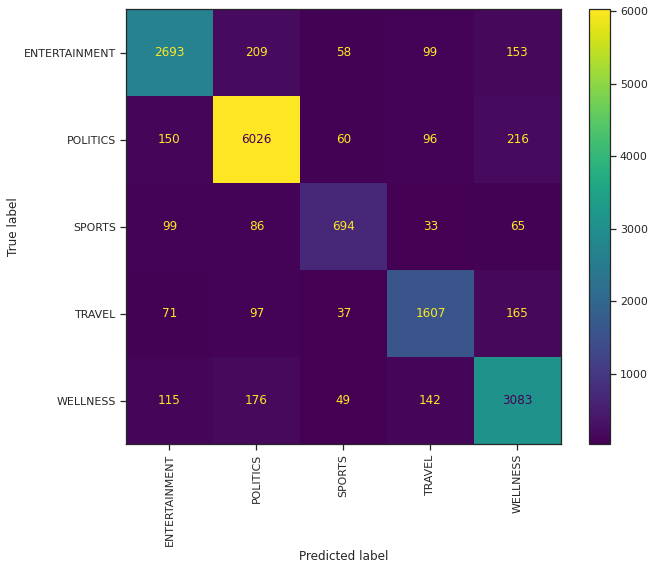

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes)

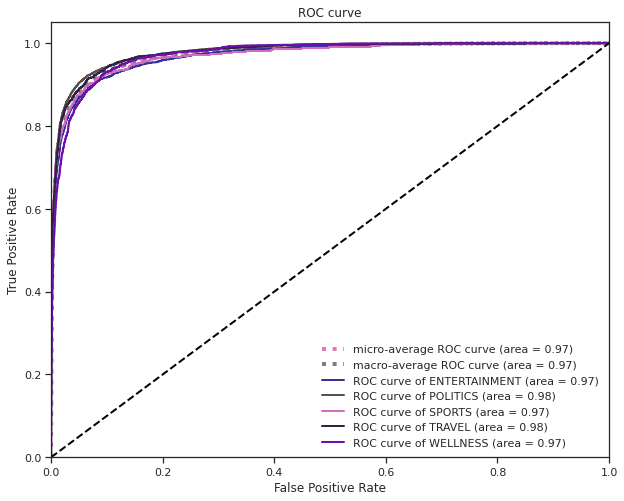

In [ ]:
plot_roc_curve(y_test, y_score, classes)

# Demo

In [ ]:
def get_random_new(news_df, classes, topic):
    sample = news_df[test_og['category'] == classes.index(topic)].sample(1).iloc[0]
    text = sample['headline']
    label = sample['category']
    return text, label



In [ ]:
class Normalizer_output:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        # Replace contractions
        text = re.sub(r"\'s", " is ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)

    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [self.ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        print('\n remove_punct:\t'+ str(text) +'\n')
        tokens = self.tokenize(text)
        print('\n tokenize:\t'+ str(tokens) +'\n')
        tokens = self.remove_stop_words(tokens)
        print('\n remove_stop_words:\t'+ str(tokens) +'\n')
        tokens = self.stemming(tokens)
        print('\n stemming:\t'+ str(tokens) +'\n')
        tokens = self.lemmatize(tokens)
        print('\n lemmatize:\t'+ str(tokens) +'\n')
        text = self.return_sentences(tokens)
        print('\n return_sentences:\t'+ str(text) +'\n')
        return text

In [ ]:
def deliver_new_hybrid(new, normalizer, encoder, svc_model, nn_model, nb_model, users, classes):
    print('Headline: ' + new)
    #print('True label: ' + classes[new[1]])
    
    new_norm = normalizer.clean_all(new)
    new_enc = encoder.transform([new_norm])
    new_enc_sorted = new_enc.sorted_indices()

    svc_idx_class = svc_model.predict(new_enc)[0]
    nb_idx_class = nb_model.predict(new_enc)[0]
    nn_idx_class = nn_model.predict(new_enc_sorted)[0].argmax()
    #add mode_idx_class for model prediction similarly


    class_nn = classes[nn_idx_class]
    class_svc = classes[svc_idx_class]
    class_nb = classes[nb_idx_class]   
    #add more class_model for class label prediction similarly

    prediction_category_list = []
    prediction_category_list.append(class_nb)
    prediction_category_list.append(class_svc)
    prediction_category_list.append(class_nn)
    #add more prediction_category_list for more model prediction similarly

    prediction_category_df =  pd.DataFrame(prediction_category_list)
    hybrid_prediction = prediction_category_df.value_counts().index.tolist()[0][0]
    
    print('Classify as: ' + hybrid_prediction)
    print('Recommended to the following users: ', end='')
    final_users = []
    for k,v in users.get_items():
        if hybrid_prediction in v:
            final_users.append(k)
    print(final_users)

Generate 10 random users for the demo

In [ ]:
users = Users(50, classes)
users.users

{'user_1': ['TRAVEL', 'WELLNESS', 'SPORTS', 'POLITICS', 'ENTERTAINMENT'],
 'user_10': ['ENTERTAINMENT', 'SPORTS'],
 'user_11': ['TRAVEL', 'POLITICS', 'WELLNESS', 'SPORTS'],
 'user_12': ['POLITICS', 'SPORTS', 'ENTERTAINMENT'],
 'user_13': ['ENTERTAINMENT', 'TRAVEL'],
 'user_14': ['POLITICS', 'WELLNESS', 'TRAVEL', 'SPORTS', 'ENTERTAINMENT'],
 'user_15': ['SPORTS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL', 'WELLNESS'],
 'user_16': ['TRAVEL', 'SPORTS', 'WELLNESS', 'ENTERTAINMENT', 'POLITICS'],
 'user_17': ['SPORTS', 'ENTERTAINMENT', 'TRAVEL', 'WELLNESS'],
 'user_18': ['TRAVEL', 'ENTERTAINMENT', 'WELLNESS'],
 'user_19': ['SPORTS', 'POLITICS', 'WELLNESS', 'TRAVEL'],
 'user_2': ['ENTERTAINMENT'],
 'user_20': ['SPORTS', 'POLITICS', 'TRAVEL', 'WELLNESS'],
 'user_21': ['ENTERTAINMENT', 'WELLNESS', 'SPORTS', 'POLITICS'],
 'user_22': ['POLITICS', 'TRAVEL'],
 'user_23': ['SPORTS', 'TRAVEL', 'WELLNESS'],
 'user_24': ['TRAVEL', 'ENTERTAINMENT', 'WELLNESS'],
 'user_25': ['SPORTS', 'POLITICS', 'ENTERTAINM

Retrieve the original test set headlines

In [ ]:
test_og = df.loc[y_test.index]

In [ ]:
norm_with_output = Normalizer_output()

Example by distributing a random category news item from test

In [ ]:
new, label = get_random_new(test_og, classes, 'POLITICS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: POLITICS
Headline: Ivanka Is Not Donald's Trump Card With Young Women

 remove_punct:	ivanka is not donald is trump card with young women


 tokenize:	['ivanka', 'is', 'not', 'donald', 'is', 'trump', 'card', 'with', 'young', 'women']


 remove_stop_words:	['ivanka', 'donald', 'trump', 'card', 'young', 'women']


 stemming:	['ivanka', 'donald', 'trump', 'card', 'young', 'women']


 lemmatize:	['ivanka', 'donald', 'trump', 'card', 'young', 'woman']


 return_sentences:	ivanka donald trump card young woman

Classify as: POLITICS
Recommended to the following users: ['user_1', 'user_6', 'user_11', 'user_12', 'user_15', 'user_16', 'user_19', 'user_21', 'user_23', 'user_25', 'user_28', 'user_29', 'user_30', 'user_32', 'user_33', 'user_34', 'user_36', 'user_40', 'user_41', 'user_42', 'user_44', 'user_45', 'user_46', 'user_47', 'user_48', 'user_49', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'RELIGION')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: RELIGION
Headline: Confessions of a Truthoholic: An Excerpt of the Truth
Classify as: PARENTING
Recommended to the following users: ['user_2', 'user_7', 'user_10', 'user_14', 'user_25', 'user_27', 'user_40', 'user_41']


In [ ]:
new, label = get_random_new(test_og, classes, 'ARTS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: ARTS
Headline: This Optical Illusion Will Make Your Eyes Bulge And Your Brain Burst
Classify as: ARTS
Recommended to the following users: ['user_2', 'user_7', 'user_8', 'user_11', 'user_18', 'user_21', 'user_37', 'user_38', 'user_47', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes, 'ARTS & CULTURE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: ARTS & CULTURE
Headline: 8 Books To Help You Celebrate The Return Of 'Broad City'
Classify as: ARTS & CULTURE
Recommended to the following users: ['user_6', 'user_7', 'user_8', 'user_11', 'user_28', 'user_40', 'user_46', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'BLACK VOICES')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: BLACK VOICES
Headline: Trayvon Martin Case Recasts Century-Old Battle Lines For Local Activist
Classify as: BLACK VOICES
Recommended to the following users: ['user_5', 'user_10', 'user_12', 'user_21']


In [ ]:
new, label = get_random_new(test_og, classes, 'BUSINESS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

NameError: ignored

In [ ]:
new, label = get_random_new(test_og, classes,'COLLEGE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: COLLEGE
Headline: UC Davis Chancellor Linda Katehi Placed On Leave Over Claims Of Ethics Violations
Classify as: COLLEGE
Recommended to the following users: ['user_18', 'user_19', 'user_35', 'user_42']


In [ ]:
new, label = get_random_new(test_og, classes,'COMEDY')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: COMEDY
Headline: Trevor Noah Just Sincerely Praised Donald Trump For Something
Classify as: COMEDY
Recommended to the following users: ['user_27', 'user_37', 'user_39', 'user_40', 'user_47']


In [ ]:
new, label = get_random_new(test_og, classes, 'CRIME')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: CRIME
Headline: Armed Fugitive Disguises Himself As An Old Man To Evade Cops
Classify as: CRIME
Recommended to the following users: ['user_2', 'user_3', 'user_5', 'user_17', 'user_19', 'user_21', 'user_28', 'user_39', 'user_43', 'user_44', 'user_47', 'user_48']


In [ ]:
new, label = get_random_new(test_og, classes,'CULTURE & ARTS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: CULTURE & ARTS
Headline: Women's History Month Artists: Celebrating WHM With Tracey Emin As The Jack Of Hearts
Classify as: CULTURE & ARTS
Recommended to the following users: ['user_4', 'user_5', 'user_7', 'user_12', 'user_14', 'user_48']


In [ ]:
new, label = get_random_new(test_og, classes,'DIVORCE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: DIVORCE
Headline: Don't Let Divorce Guilt Break Your Bank
Classify as: DIVORCE
Recommended to the following users: ['user_6', 'user_8', 'user_12', 'user_24', 'user_31', 'user_38', 'user_39']


In [ ]:
new, label = get_random_new(test_og, classes,'EDUCATION')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: EDUCATION
Headline: An "Informed Consumer" of Students' Test Scores
Classify as: EDUCATION
Recommended to the following users: ['user_2', 'user_4', 'user_27', 'user_34', 'user_39', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes,'ENTERTAINMENT')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: ENTERTAINMENT
Headline: Seth Rogen Lip-Syncing 'Hotline Bling' Is Seriously The Best

 remove_punct:	seth rogen lip syncing hotline bling is seriously the best


 tokenize:	['seth', 'rogen', 'lip', 'syncing', 'hotline', 'bling', 'is', 'seriously', 'the', 'best']


 remove_stop_words:	['seth', 'rogen', 'lip', 'syncing', 'hotline', 'bling', 'seriously', 'best']


 stemming:	['seth', 'rogen', 'lip', 'sync', 'hotlin', 'bling', 'serious', 'best']


 lemmatize:	['seth', 'rogen', 'lip', 'sync', 'hotlin', 'bling', 'serious', 'best']


 return_sentences:	seth rogen lip sync hotlin bling serious best

Classify as: ENTERTAINMENT
Recommended to the following users: ['user_1', 'user_3', 'user_4', 'user_7', 'user_8', 'user_11', 'user_12', 'user_14', 'user_17', 'user_18', 'user_21', 'user_22', 'user_23', 'user_25', 'user_26', 'user_27', 'user_29', 'user_30', 'user_31', 'user_32', 'user_34', 'user_36', 'user_37', 'user_38', 'user_40', 'user_43', 'user_45', 'user_46', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes,'ENVIRONMENT')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: ENVIRONMENT
Headline: Palo Verde Beetles, Huge Horny Bugs, Descend On Arizona Looking For Love (VIDEO)
Classify as: LATINO VOICES
Recommended to the following users: ['user_6', 'user_11', 'user_20', 'user_25', 'user_31']


In [ ]:
new, label = get_random_new(test_og, classes, 'FIFTY')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: FIFTY
Headline: Cassandra Wilson Says 'Happy 100th, Lady Day'
Classify as: FIFTY
Recommended to the following users: ['user_8', 'user_10', 'user_15', 'user_16', 'user_19', 'user_21', 'user_37', 'user_39', 'user_46', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes,'FOOD & DRINK')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: FOOD & DRINK
Headline: Top 10 Tequilas
Classify as: FOOD & DRINK
Recommended to the following users: ['user_2', 'user_5', 'user_12', 'user_14', 'user_16', 'user_33', 'user_34', 'user_37', 'user_44', 'user_46']


In [ ]:
new, label = get_random_new(test_og, classes, 'GOOD NEWS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: GOOD NEWS
Headline: These Affectionate Doggie Pals Will Make You Wanna Hug Your BFF
Classify as: GOOD NEWS
Recommended to the following users: ['user_4', 'user_6', 'user_16', 'user_26', 'user_45', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'GREEN')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: GREEN
Headline: A Photo From The Moscow Zoo Vividly Captures Life In Captivity
Classify as: ENVIRONMENT
Recommended to the following users: ['user_2', 'user_3', 'user_8', 'user_14', 'user_22', 'user_32', 'user_40', 'user_42', 'user_45', 'user_46', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'HEALTHY LIVING')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: HEALTHY LIVING
Headline: When Did I Become A Person With Allergies?!
Classify as: HEALTHY LIVING
Recommended to the following users: ['user_1', 'user_8', 'user_11', 'user_34', 'user_41', 'user_44', 'user_48', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes,'HOME & LIVING')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: HOME & LIVING
Headline: How To Remove Mold From Your Bathtub
Classify as: HOME & LIVING
Recommended to the following users: ['user_10', 'user_12', 'user_26', 'user_35', 'user_40', 'user_44', 'user_45']


In [ ]:
new, label = get_random_new(test_og, classes,'IMPACT')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: IMPACT
Headline: What Does the First Tycoon Tell Us About Capitalism?
Classify as: BUSINESS
Recommended to the following users: ['user_4', 'user_6', 'user_14', 'user_33', 'user_37']


In [ ]:
new, label = get_random_new(test_og, classes,'LATINO VOICES')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: LATINO VOICES
Headline: Laurie Hernandez's Agent Says Brands Are Lining Up To Work With The Olympian
Classify as: LATINO VOICES
Recommended to the following users: ['user_6', 'user_11', 'user_20', 'user_25', 'user_31']


In [ ]:
new, label = get_random_new(test_og, classes,'MEDIA')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: MEDIA
Headline: The Attack On Charlie Hebdo Was A Symbolic Tragedy So Quit Trying To Change The Subject
Classify as: WORLDPOST
Recommended to the following users: ['user_5', 'user_7', 'user_10', 'user_15', 'user_22', 'user_32', 'user_36', 'user_39']


In [ ]:
new, label = get_random_new(test_og, classes,'MONEY')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: MONEY
Headline: Why Wanting to Be Rich Is a Form of Mental Illness
Classify as: HEALTHY LIVING
Recommended to the following users: ['user_1', 'user_8', 'user_11', 'user_34', 'user_41', 'user_44', 'user_48', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes,'PARENTING')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: PARENTING
Headline: Splish Splash! Kids' Water Shoes That Protect At Play
Classify as: PARENTING
Recommended to the following users: ['user_2', 'user_7', 'user_10', 'user_14', 'user_25', 'user_27', 'user_40', 'user_41']


In [ ]:
new, label = get_random_new(test_og, classes,'PARENTS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: PARENTS
Headline: How to Breastfeed Twins in Public
Classify as: PARENTS
Recommended to the following users: ['user_1', 'user_5', 'user_10', 'user_15', 'user_18', 'user_31', 'user_37', 'user_39', 'user_48', 'user_49', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes,'QUEER VOICES')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: QUEER VOICES
Headline: My Child Is 'They,' And It's Society, Not Language, That Needs Fixing
Classify as: PARENTING
Recommended to the following users: ['user_2', 'user_7', 'user_10', 'user_14', 'user_25', 'user_27', 'user_40', 'user_41']


In [ ]:
new, label = get_random_new(test_og, classes,'SCIENCE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: SCIENCE
Headline: Slave Tunnels Found In Massive Network Underneath Second Century Roman Emperor's Villa
Classify as: SPORTS
Recommended to the following users: ['user_4', 'user_5', 'user_12', 'user_19', 'user_21', 'user_22', 'user_23', 'user_29', 'user_31', 'user_38', 'user_39', 'user_41', 'user_43', 'user_44', 'user_47', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'SPORTS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: SPORTS
Headline: Mirai Nagasu Says Her Parents' Hard Work In Restaurant Inspires Her Discipline On Ice
Classify as: PARENTING
Recommended to the following users: ['user_2', 'user_7', 'user_10', 'user_14', 'user_25', 'user_27', 'user_40', 'user_41']


In [ ]:
new, label = get_random_new(test_og, classes, 'STYLE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: STYLE
Headline: Move Over, Clooney: Steve Carell Is Our Favorite Silver Fox Now
Classify as: MEDIA
Recommended to the following users: ['user_1', 'user_4', 'user_25', 'user_37', 'user_45']


In [ ]:
new, label = get_random_new(test_og, classes,'STYLE & BEAUTY')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: STYLE & BEAUTY
Headline: The Met Ball
Classify as: SPORTS
Recommended to the following users: ['user_4', 'user_5', 'user_12', 'user_19', 'user_21', 'user_22', 'user_23', 'user_29', 'user_31', 'user_38', 'user_39', 'user_41', 'user_43', 'user_44', 'user_47', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'TASTE')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: TASTE
Headline: Dippin' Dots Responds To Sean Spicer With An Ice-Cold Burn
Classify as: COMEDY
Recommended to the following users: ['user_27', 'user_37', 'user_39', 'user_40', 'user_47']


In [ ]:
new, label = get_random_new(test_og, classes,'TECH')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: TECH
Headline: Facebook Takes A Step Toward Virtual Reality With New 360-Degree Videos
Classify as: TECH
Recommended to the following users: ['user_6', 'user_11', 'user_16', 'user_18', 'user_26', 'user_34']


In [ ]:
new, label = get_random_new(test_og, classes,'THE WORLDPOST')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: THE WORLDPOST
Headline: Aleppo Residents Burn Tires To Obstruct Warplanes Bombarding Their City
Classify as: THE WORLDPOST
Recommended to the following users: ['user_2', 'user_16', 'user_34', 'user_35', 'user_36', 'user_41', 'user_45']


In [ ]:
new, label = get_random_new(test_og, classes,'TRAVEL')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: TRAVEL
Headline: 21 Travel Photos That'll Re-Ignite Your Sense Of Wanderlust
Classify as: TRAVEL
Recommended to the following users: ['user_3', 'user_10', 'user_16', 'user_20', 'user_22', 'user_23', 'user_24', 'user_27', 'user_34', 'user_40', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes, 'WEDDINGS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WEDDINGS
Headline: Usher: Wedding Singer? Yes, If One Mom Has Her Way
Classify as: WEDDINGS
Recommended to the following users: ['user_4', 'user_6', 'user_27', 'user_32', 'user_35', 'user_37', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes, 'WEIRD NEWS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WEIRD NEWS
Headline: Sweden's Gigantic Straw Christmas Goat Goes Up In Flames... Again
Classify as: WEIRD NEWS
Recommended to the following users: ['user_5', 'user_19', 'user_27', 'user_31', 'user_36', 'user_40', 'user_45']


In [ ]:
new, label = get_random_new(test_og, classes, 'WELLNESS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WELLNESS
Headline: Does Self-Compassion Mean Letting Yourself Off the Hook?

 remove_punct:	does self compassion mean letting yourself off the hook


 tokenize:	['does', 'self', 'compassion', 'mean', 'letting', 'yourself', 'off', 'the', 'hook']


 remove_stop_words:	['self', 'compassion', 'mean', 'letting', 'hook']


 stemming:	['self', 'compass', 'mean', 'let', 'hook']


 lemmatize:	['self', 'compass', 'mean', 'let', 'hook']


 return_sentences:	self compass mean let hook

Classify as: WELLNESS
Recommended to the following users: ['user_1', 'user_5', 'user_6', 'user_7', 'user_9', 'user_11', 'user_16', 'user_17', 'user_18', 'user_20', 'user_21', 'user_22', 'user_26', 'user_27', 'user_29', 'user_31', 'user_32', 'user_36', 'user_38', 'user_40', 'user_41', 'user_42', 'user_43', 'user_46', 'user_47', 'user_49', 'user_50']


In [ ]:
new, label = get_random_new(test_og, classes, 'WOMEN')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WOMEN
Headline: My Biological Clock Is Defective
Classify as: SCIENCE
Recommended to the following users: ['user_1', 'user_19', 'user_30', 'user_31', 'user_37', 'user_40', 'user_44', 'user_47', 'user_48']


In [ ]:
new, label = get_random_new(test_og, classes, 'WORLD NEWS')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WORLD NEWS
Headline: Indian Prime Minister Leads Nationalist Charge To Rewrite History Books
Classify as: POLITICS
Recommended to the following users: ['user_5', 'user_10', 'user_16', 'user_21', 'user_34', 'user_44', 'user_46', 'user_49']


In [ ]:
new, label = get_random_new(test_og, classes, 'WORLDPOST')
print("Actual Label: " + str(classes[label]))
deliver_new_hybrid(new, norm_with_output, tfidf, svc_clf, model, nb_clf, users, classes)

Actual Label: WORLDPOST
Headline: What Does German Unity Mean to the Post-Cold War Generation?
Classify as: WORLDPOST
Recommended to the following users: ['user_5', 'user_7', 'user_10', 'user_15', 'user_22', 'user_32', 'user_36', 'user_39']


In [ ]:
classes

['ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']